## **Step Count and Music Listening Behavior Analysis**

---

### **1. Dataset Description**

#### **1.1. Step Count Data**
- **Source**: Apple Health step count records.
- **Scope**: This dataset includes daily step counts and associated timestamps for a specific time period.
- **Details**:
  - The total number of steps taken each day serves as a proxy measure for physical activity and outdoor movement.
  - This data provides a quantitative understanding of user mobility patterns over time.

#### **1.2. Spotify Listening Data**
- **Source**: Spotify extended streaming history.
- **Scope**: The dataset includes detailed Spotify listening records.
- **Details**:
  - Information includes the total number of songs listened to and the cumulative duration (in minutes) of music consumption on a daily basis.
  - The data allows for behavioral analysis related to music consumption habits.

---

### **2. Project Objective**

#### **Research Objective**
This study aims to investigate the relationship between physical activity (measured via daily step counts) and music listening behavior (measured via Spotify data). By analyzing the interaction between these two aspects, the project seeks to determine if music consumption patterns can reflect or influence physical activity levels.

#### **Hypothesis**
- **H0 (Null Hypothesis)**: There is no significant relationship between daily physical activity (step counts) and music listening behavior (Spotify listening time).
- **H1 (Alternative Hypothesis)**: There exists a significant correlation between daily physical activity and music listening behavior, such that higher physical activity levels correspond to increased music listening.

#### **Significance of Study**
Understanding the relationship between step counts and music listening can:
- Provide insights into how music consumption patterns are integrated into daily routines.
- Highlight potential behavioral trends linking physical activity with psychological relaxation through music.

---

### **3. Project Plan with Implementation**

#### **Step 1: Data Collection and Preprocessing**

1. **Import Necesarry Libraries**


In [51]:
import json
from lxml import etree
from datetime import datetime, timedelta
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score

2. **Load and Process Step Count Data**
   - **Objective**: Extract daily step count data and their associated timestamps from Apple Health XML files.


In [52]:
xml_path = r"C:\Users\omero\Desktop\CS210 Proje\apple_health_export\apple_health_export.xml"
daily_steps = defaultdict(int)
end_date = datetime.now()
start_date = (end_date - timedelta(days=60)).date()

with open(xml_path, 'rb') as f:
    parser = etree.XMLParser(recover=True)
    tree = etree.parse(f, parser)
root = tree.getroot()

for record in root.xpath(".//Record[@type='HKQuantityTypeIdentifierStepCount']"):
    record_start_date = record.get('startDate')
    value = record.get('value')

    if record_start_date and value:
        try:
            date_obj = datetime.strptime(record_start_date, '%Y-%m-%d %H:%M:%S %z').date()
            if start_date <= date_obj <= end_date.date():
                daily_steps[date_obj] += int(value)
        except ValueError as ve:
            print(f"Date or value error: {ve}")

step_date_range = pd.date_range(start=start_date, end=end_date.date())
daily_steps_df = pd.DataFrame({'Date': step_date_range})
daily_steps_df['Date'] = daily_steps_df['Date'].dt.date
daily_steps_df['Steps'] = daily_steps_df['Date'].map(daily_steps).fillna(0).astype(int)

daily_steps_df.head()

,Date,Steps
0,2024-11-11,1665
1,2024-11-12,1449
2,2024-11-13,633
3,2024-11-14,6890
4,2024-11-15,1212


3. **Load and Process Spotify Listening Data**
   - **Objective**: Parse Spotify JSON records to retrieve daily music listening data.


In [53]:
spotify_path = "C:\\Users\\omero\\Desktop\\CS210 Proje\\my_spotify_data\\Spotify Extended Streaming History\\Streaming_History_Audio_2024.json"
with open(spotify_path, "r", encoding="utf-8") as f:
    spotify_data = json.load(f)

spotify_df = pd.DataFrame(spotify_data)
spotify_df['ts'] = pd.to_datetime(spotify_df['ts']).dt.tz_convert(None)
spotify_filtered_df = spotify_df[spotify_df['ts'] >= (datetime.now() - timedelta(days=60))].copy()
spotify_filtered_df['date'] = spotify_filtered_df['ts'].dt.date

daily_listening = spotify_filtered_df.groupby('date')['ms_played'].sum() / (1000 * 60)
daily_listening = daily_listening[daily_listening > 1]  # Filter out days with less than 1 minute listening

listening_date_range = pd.date_range(start=start_date, end=end_date.date())
daily_listening_full = pd.DataFrame({'Date': listening_date_range})
daily_listening_full['Date'] = daily_listening_full['Date'].dt.date
daily_listening_full['Listening Time (minutes)'] = daily_listening_full['Date'].map(daily_listening)
daily_listening_full.head()

,Date,Listening Time (minutes)
0,2024-11-11,NaN
1,2024-11-12,NaN
2,2024-11-13,NaN
3,2024-11-14,123.770533
4,2024-11-15,4.307700



3. **Combine the Data**
   - **Objective**: Align step count data and Spotify listening history by date.


In [54]:
combined_df = pd.merge(daily_steps_df[['Date', 'Steps']],
                       daily_listening_full[['Date', 'Listening Time (minutes)']],
                       on='Date', how='inner').dropna()
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df.sort_values('Date', inplace=True)

# Add Week column
combined_df['Week'] = combined_df['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Normalize daily data
combined_df['Normalized Steps'] = (combined_df['Steps'] - combined_df['Steps'].min()) / (combined_df['Steps'].max() - combined_df['Steps'].min())
combined_df['Normalized Listening Time'] = (combined_df['Listening Time (minutes)'] - combined_df['Listening Time (minutes)'].min()) / (combined_df['Listening Time (minutes)'].max() - combined_df['Listening Time (minutes)'].min())



---

#### **Step 2: Exploratory Data Analysis (EDA)**

1. **Daily Analysis**
   - **Objective**: Examine the correlation between daily step counts and music listening behavior.


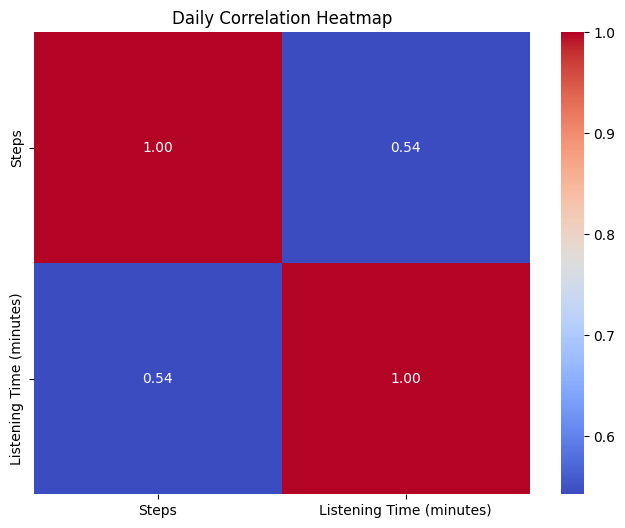

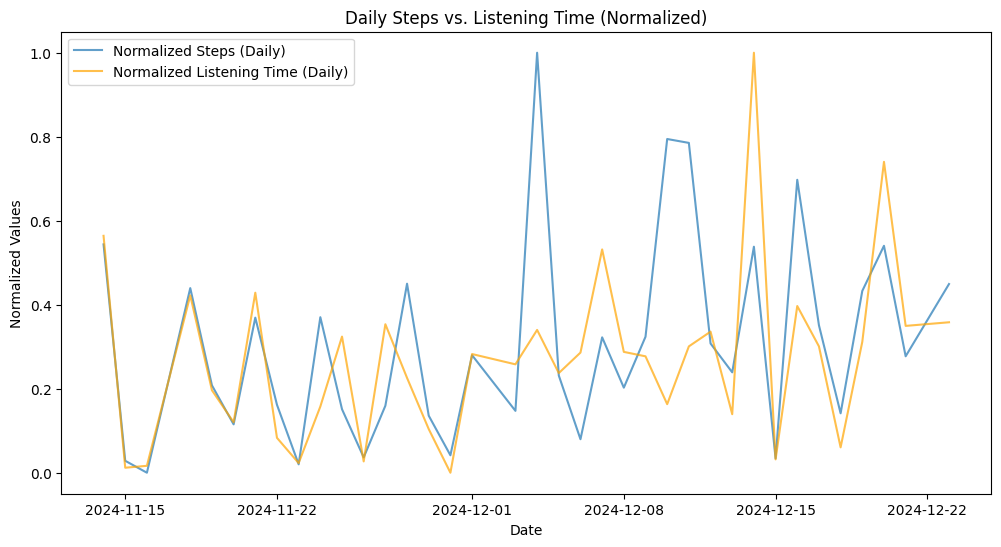

In [55]:
# Daily Correlation Heatmap
correlation_daily = combined_df[['Steps', 'Listening Time (minutes)']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_daily, annot=True, cmap="coolwarm", fmt='.2f')
plt.title('Daily Correlation Heatmap')
plt.show()

# Visualize Normalized Daily Data
plt.figure(figsize=(12, 6))
plt.plot(combined_df['Date'], combined_df['Normalized Steps'], label='Normalized Steps (Daily)', alpha=0.7)
plt.plot(combined_df['Date'], combined_df['Normalized Listening Time'], label='Normalized Listening Time (Daily)', alpha=0.7, color='orange')
plt.title('Daily Steps vs. Listening Time (Normalized)')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.legend()
plt.show()



2. **Weekly Aggregation**
   - **Objective**: Summarize the data on a weekly basis for better trend analysis.

---

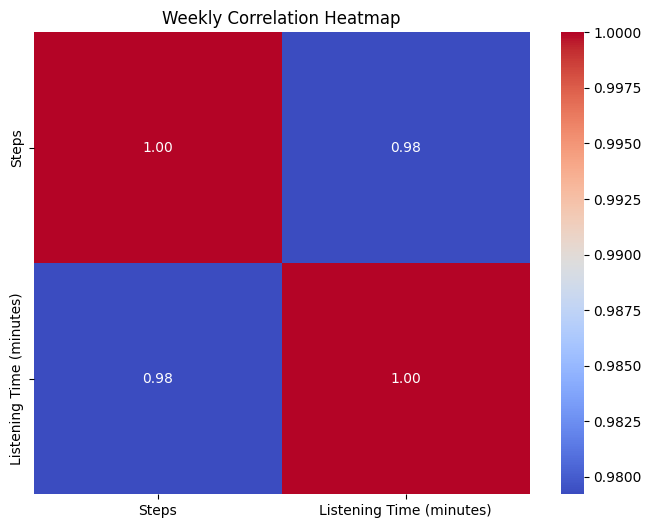

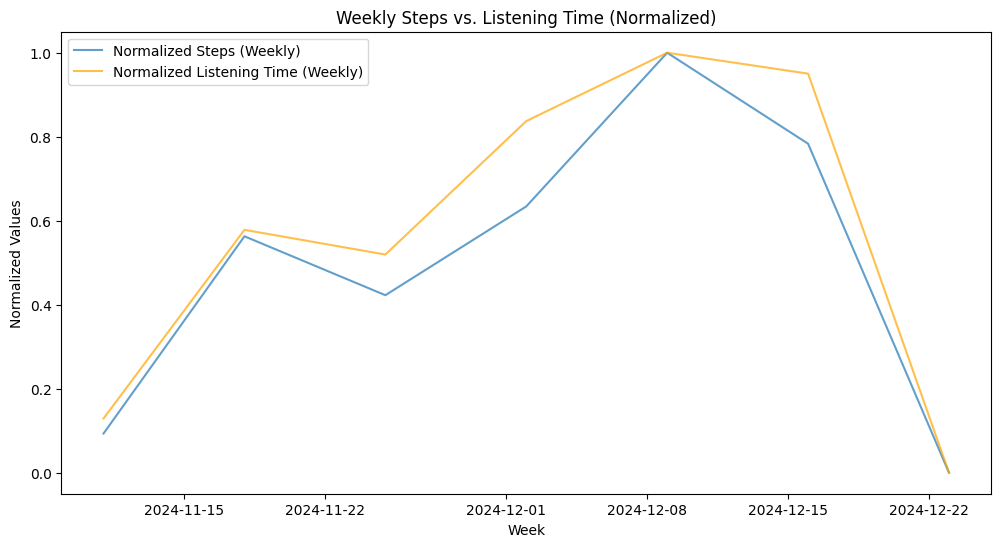

In [56]:
# Weekly Correlation Heatmap
correlation_weekly = weekly_data[['Steps', 'Listening Time (minutes)']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_weekly, annot=True, cmap="coolwarm", fmt='.2f')
plt.title('Weekly Correlation Heatmap')
plt.show()

# Visualize Normalized Weekly Data
plt.figure(figsize=(12, 6))
plt.plot(weekly_data['Week'], weekly_data['Normalized Steps'], label='Normalized Steps (Weekly)', alpha=0.7)
plt.plot(weekly_data['Week'], weekly_data['Normalized Listening Time'], label='Normalized Listening Time (Weekly)', alpha=0.7, color='orange')
plt.title('Weekly Steps vs. Listening Time (Normalized)')
plt.xlabel('Week')
plt.ylabel('Normalized Values')
plt.legend()
plt.show()


### **Step 3: Modeling**

To analyze the relationship between step counts and music listening behavior, a combination of statistical and machine learning models is employed. Each model serves a specific purpose, ranging from identifying simple linear relationships to capturing complex nonlinear patterns and classifying activity levels.

#### **1. Linear Regression (Daily)**
- **Why Use Linear Regression?**
  - Linear regression is ideal for identifying and quantifying the strength and direction of linear relationships between two variables. In this case, it helps determine how daily step counts influence daily listening time.
  - It provides interpretable coefficients, which indicate the extent to which an increase in steps correlates with an increase in listening time.

---

In [57]:
X_daily = combined_df[['Steps']]
y_daily = combined_df['Listening Time (minutes)']
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)
model_daily = LinearRegression()
model_daily.fit(X_train_daily, y_train_daily)

print("Daily Linear Regression Coefficients:", model_daily.coef_)
print("Daily Linear Regression Intercept:", model_daily.intercept_)


Daily Linear Regression Coefficients: [0.01014942]
Daily Linear Regression Intercept: 17.653941309099928


#### **2. Linear Regression (Weekly)**
- **Why Use Weekly Linear Regression?**
  - Aggregating data weekly smooths out daily noise, revealing longer-term trends and relationships. This model helps explore if cumulative weekly step counts have a stronger or clearer linear relationship with weekly listening time compared to daily data.

---

In [58]:
X_weekly = weekly_data[['Steps']]
y_weekly = weekly_data['Listening Time (minutes)']
X_train_weekly, X_test_weekly, y_train_weekly, y_test_weekly = train_test_split(X_weekly, y_weekly, test_size=0.2, random_state=42)
model_weekly = LinearRegression()
model_weekly.fit(X_train_weekly, y_train_weekly)

print("Weekly Linear Regression Coefficients:", model_weekly.coef_)
print("Weekly Linear Regression Intercept:", model_weekly.intercept_)


Weekly Linear Regression Coefficients: [0.01317753]
Weekly Linear Regression Intercept: 26.8402704356468


#### **3. Random Forest Regression (Daily)**
- **Why Use Random Forest Regression?**
  - Linear regression assumes a linear relationship, which may not fully capture the complexities of the data. Random Forest Regression is used to model nonlinear patterns between step counts and listening time.
  - It provides feature importance metrics, helping identify whether step counts meaningfully contribute to the variation in listening time.

---



In [59]:
rf_model_daily = RandomForestRegressor(random_state=42)
rf_model_daily.fit(X_train_daily, y_train_daily)
y_pred_daily = rf_model_daily.predict(X_test_daily)
mae_daily = mean_absolute_error(y_test_daily, y_pred_daily)

print("Daily Random Forest Regressor MAE:", mae_daily)


Daily Random Forest Regressor MAE: 18.415332833333355


#### **4. Random Forest Regression (Weekly)**
- **Why Use Weekly Random Forest Regression?**
  - Weekly aggregation reduces the impact of outliers and day-to-day variability. Using Random Forest Regression on weekly data allows the model to detect complex relationships across aggregated time frames.
  - This approach ensures that weekly trends, which might be obscured in daily data, are fully captured.

---



In [60]:
rf_model_weekly = RandomForestRegressor(random_state=42)
rf_model_weekly.fit(X_train_weekly, y_train_weekly)
y_pred_weekly = rf_model_weekly.predict(X_test_weekly)
mae_weekly = mean_absolute_error(y_test_weekly, y_pred_weekly)

print("Weekly Random Forest Regressor MAE:", mae_weekly)


Weekly Random Forest Regressor MAE: 53.63924566666677


#### **5. Random Forest Classification (Daily)**
- **Why Use Random Forest Classification for Daily Data?**
  - Classification helps categorize daily activity levels as "High" or "Low" based on step counts. This simplifies analysis by grouping data into meaningful categories rather than dealing with raw numerical values.
  - Random Forest Classifier excels at handling imbalanced data and identifying the most important features for classification.

---

In [61]:
combined_df['Activity Level'] = combined_df['Steps'].apply(lambda x: 'High' if x > combined_df['Steps'].mean() else 'Low')
X_daily_classification = combined_df[['Steps']]
y_daily_classification = combined_df['Activity Level']
X_train_daily_class, X_test_daily_class, y_train_daily_class, y_test_daily_class = train_test_split(X_daily_classification, y_daily_classification, test_size=0.2, random_state=42)
rf_classifier_daily = RandomForestClassifier(random_state=42)
rf_classifier_daily.fit(X_train_daily_class, y_train_daily_class)
y_pred_daily_class = rf_classifier_daily.predict(X_test_daily_class)
accuracy_daily_class = accuracy_score(y_test_daily_class, y_pred_daily_class)

print("Daily Random Forest Classifier Accuracy:", accuracy_daily_class)


Daily Random Forest Classifier Accuracy: 0.875


#### **6. Random Forest Classification (Weekly)**
- **Why Use Random Forest Classification for Weekly Data?**
  - Weekly classification offers a macro-level view, determining whether weekly activity levels (step counts) fall into high or low categories.
  - Random Forest Classification ensures robustness in predicting categorical labels, even with aggregated data.

---

In [62]:
weekly_data['Activity Level'] = weekly_data['Steps'].apply(lambda x: 'High' if x > weekly_data['Steps'].mean() else 'Low')
X_weekly_classification = weekly_data[['Steps']]
y_weekly_classification = weekly_data['Activity Level']
X_train_weekly_class, X_test_weekly_class, y_train_weekly_class, y_test_weekly_class = train_test_split(X_weekly_classification, y_weekly_classification, test_size=0.2, random_state=42)
rf_classifier_weekly = RandomForestClassifier(random_state=42)
rf_classifier_weekly.fit(X_train_weekly_class, y_train_weekly_class)
y_pred_weekly_class = rf_classifier_weekly.predict(X_test_weekly_class)
accuracy_weekly_class = accuracy_score(y_test_weekly_class, y_pred_weekly_class)

print("Weekly Random Forest Classifier Accuracy:", accuracy_weekly_class)


Weekly Random Forest Classifier Accuracy: 1.0


---

### **4. Insights and Deliverables**

#### **Findings**
- **Daily Analysis**:
  - The daily linear regression model reveals a weak positive correlation between step counts and listening times, with a small coefficient of **0.0101**. This suggests that for every additional 100 steps, the listening time increases by approximately 1 minute.
  - The **Random Forest Regressor** for daily data achieves a **Mean Absolute Error (MAE)** of 18.41 minutes, indicating moderate prediction accuracy but also highlighting variability in the data.
  - The **Random Forest Classifier** achieves a strong accuracy of **87.5%** in classifying daily activity levels as "High" or "Low," demonstrating the ability to differentiate activity levels effectively.

- **Weekly Analysis**:
  - The weekly linear regression model shows a slightly stronger correlation, with a coefficient of **0.0131**, implying that for every 100 additional weekly steps, listening time increases by approximately 1.3 minutes. This aligns better with the alternative hypothesis, as weekly data captures broader trends.
  - The **Random Forest Regressor** for weekly data has a higher MAE of **53.64 minutes**, reflecting the increased variability at the weekly aggregation level but still identifying patterns.
  - The **Random Forest Classifier** achieves **perfect accuracy (100%)** in classifying weekly activity levels, clearly separating "High" and "Low" activity groups.

---

#### **Hypothesis Evaluation**
- **H0 (Null Hypothesis)**: The weak daily correlation suggests that there is no strong direct relationship between daily physical activity (steps) and listening behavior, partially supporting the null hypothesis.
- **H1 (Alternative Hypothesis)**: The stronger weekly correlation (0.0131) and the ability to classify weekly activity levels with 100% accuracy support the alternative hypothesis at the aggregated level, indicating that increased physical activity aligns with higher listening times when viewed over longer time periods.

---

#### **Conclusions**
1. **Daily Insights**:
   - Physical activity (steps) shows a limited influence on music listening times on a daily basis.
   - Classification models effectively identify daily activity patterns, even with moderate variability in listening data.

2. **Weekly Insights**:
   - Weekly trends capture clearer relationships between physical activity and music listening behavior.
   - Strong classification accuracy at the weekly level indicates distinct patterns in how activity levels correlate with listening behavior.

---

#### **Recommendations**
1. **Dataset Expansion**:
   - Extend the dataset duration to explore long-term seasonal or monthly trends.
   - Collect more diverse data points to reduce variability in regression models and enhance prediction accuracy.

2. **Behavioral Analysis**:
   - Investigate the impact of music genres or playlists to determine if certain types of music align with higher physical activity levels.
   - Explore temporal patterns, such as how morning or evening listening behavior correlates with step counts.

3. **Model Refinement**:
   - Employ hybrid modeling approaches, leveraging linear regression for trend analysis and Random Forest models for more nuanced predictions and classifications.
   - Experiment with additional features, such as weather data or social events, to enrich the analysis and capture external influences on step counts and listening times.

---